## cloth_detection.ipynbで学習したモデルの重みをインポートしてテストを行う
## Test for images with Leared model by cloth_detection.ipynb

## 1. import 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.__version__

'1.8.0'

## 2. config for test



In [3]:
class ClothConfig(Config):

    
    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        #self.IMAGE_SHAPE = np.array(
        #    [self.IMAGE_MIN_DIM, self.IMAGE_MAX_DIM, 3]) #changed 02/27
        self.IMAGE_SHAPE = np.array(
            [self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM, 3])
        
        
        # Compute backbone size from input image size
        self.BACKBONE_SHAPES = np.array(
            [[int(math.ceil(self.IMAGE_SHAPE[0] / stride)),
              int(math.ceil(self.IMAGE_SHAPE[1] / stride))]
             for stride in self.BACKBONE_STRIDES])
    
    
    # Give the configuration a recognizable name
    NAME = "clothes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256#320
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ClothConfig()
#config.display()

## 3. Read test data

In [4]:
#画像データはarray型にする。
import cv2

#pngデータ読込
image_num = 10
images = []
labels = []

size_tmp = 256, 256

for i in range(image_num):
    try:
        #画像読込
        img_name = "./test_image/test" + str(i+1) + ".JPG"
        img = cv2.imread(img_name)
        img = cv2.resize(img,(256,256))
        images.append(img)
        #ラベル画像読込
        """
        label_name = "./test_Label/" + str(i) + "_ex1_label.png"
        label = cv2.imread(label_name)
        label = cv2.resize(label, (256,256))
        labels.append(label)
        """
        
    except:
        print("Error. No such file or directory: " + img_name)
        #print("Error. No such file or directory: " + label_name)
        
dataset_test = np.array(images)
print("(データ数, H, W, RGBの3) = ", dataset_test.shape)

(データ数, H, W, RGBの3) =  (10, 256, 256, 3)


### Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### 4.5 データセットの型を整える(model setup)

In [6]:
num_train = 400
num_test = 99

class ClothesDataset(utils.Dataset):
    
    
    def load_clothes(self, count, width, height, flag):
        #classを追加
        
        import json
        from statistics import mean, median,variance,stdev
        #self.add_class("clothes",0,"BG")
        self.add_class("clothes",1,"tg")
        self.add_class("clothes",2,"tw")
        bg_color = [255, 255, 255]
        
        print("count", count)
        
        for i in range(count): #衣服画像の枚数だけ繰り返す
            
        #1. クラスラベルの情報(位置、色情報など)をshapesに格納し、 
            shapes = []
            
            if(flag == 1):
                ID = i + num_train #連番の最後の方をテスト用にしているので 0301 pancho
            elif(flag==2):
                ID = i + 1 #1スタートなので
            else: ID = i
            
            print(flag)
            
            if(flag == 0):# for train data
                json_name = "./train2/" + str(ID) + "_ex1.json"
            elif(flag == 2): #for test data 
                json_name = "./test_image/test" + str(ID) + ".json"
                print("Now Loaded...test" + str(ID) + ".json")
            #for validation data
            else: json_name = "./test2/" + str(ID) + "_ex1.json" #for validation data
            
            f = open(json_name)
            data = json.load(f)
            json_label_num = len(data["shapes"]) #num pf shapes on each image

            #json_label_num = 2
            #print(json_label_num)
            
            
            for j in range(json_label_num):#i番目の画像に存在するインスタンスの数だけ繰り返す
            #for j in range(2):
                label = data["shapes"][j]["label"]
                points = np.array(data["shapes"][j]["points"]) #convert to array to calculate
                #中心点を求める
                x_center = int(mean(points[:,0]))
                y_center = int(mean(points[:,1]))
                #size will be the bigger one by compareing x_width with y_width
                x_width = max(points[:,0]) - min(points[:,0])
                y_width = max(points[:,1]) - min(points[:,1])
                if(x_width > y_width):
                    size = int(x_width+10) 
                else: size = int(y_width+10)
    
                if(label =="tg"):#green Tshirts
                    color = (255,0,0) # RED for tg
                elif(label == "tw"): 
                    color = (0,0,255) #BLUE for tw
    
                else: print("ERROR. the object has no class id like \"tg\"")
    
                #set defined Data for "self.add_image"
                data_to_shapes = (label, color, (x_center, y_center, size))
            
                if label == "tg":
                    shapes.append(data_to_shapes)
                else: shapes.insert(0,data_to_shapes) 
                    
            #print(i, "th \"shapes\". ", shapes)
            #print(i ,"th bg_color. ", bg_color)
            #print("\n")
            
            if ID >= 90:
                path = "./test/" + str(ID) + "_ex1.png"     
            else:
                path = "./train/" + str(ID) + "_ex1.png"  
            
            #print("load_clothes. id. ", i)
            
            self.add_image("clothes", image_id = ID, path = path,
                            width = width, height = height,
                            bg_color = bg_color, clothes = shapes)
                
                
        
        
            
    def load_image (self, image_id):
        width = 256
        height = 256
        test_start_id = 90
        
        info = self.image_info[image_id]
        
        print("image_id in [load_image].", image_id)
        
        """ # temprary change the code for test data
        if image_id >= test_start_id: #90番目以降はテスト用
            img_name = "./test/" + str(image_id) + "_ex1.png"
        else:
            img_name =  "./train/" + str(image_id) + "_ex1.png"
        """
        img_name = "./test_image/test" + str(image_id) + ".JPG"
        image = cv2.imread(img_name)
   
        image = cv2.resize(image,(width,height))
        return image[:,:,::-1]
        
    
        
        
            
    def image_reference(self, image_id):
        info = self.image_info[image_id] 
        if info["source"] == "clothes":
            return info["clothes"]
        else:
            super(self.__class__).image_reference(self, image_id)

            
    
    def load_mask(self, image_id):
        """
        データセットによってmaskを格納する方法は異なる。
        
        戻り値(2つ). 
            mask (numpy array型)
                インスタンス毎に1つのmaskを用意し、その配列として返す
            class_ids.(numpy adday型)
                画像中のインスタンス毎にIDを付与し、それを1D配列として格納したもの。
        
        """
        
        info = self.image_info[image_id] #image_idに関する各種情報を取ってくる。
        shapes = info['clothes']
        width = info["width"]
        height = info["height"]
        print("image_id", image_id)
        print("shapes", shapes)
        count = len(shapes)  #背景を除くインスタンスの数 len(shapes)にしたらオブジェクトが3個以上になるので
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
      
        print("enter_mask _R-CNN")
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        
        """
        色付けしたラベル画像をみていく。
        もし色が赤、あるいは青であれば、
            mask[i][j]["対応するクラス番号. tgなら1なので0(サイズ2なので)"] = 255
            mask[i][j]["上以外の番号.今回は2つだけなので余った1つ"] = 0
        
        """
        #label_name = "./Label/" + str(image_id) + "_ex1_label.png"
        label_name = "./test_image/test" + str(image_id) + "_label.png"
        label_img = cv2.imread(label_name)
        
        label_img = cv2.resize(label_img,(width,height))
        
        print("width", width)
        print("height", height)
        
        
        for i in range(width):
            for j in range(height):
                #print("(i,j) = (", i, j, ")")
                if np.allclose(label_img[i][j], np.array([0, 0, 255]) ): #赤色のところはラベル付したところとみなす
                    mask[i][j][0] = 255 #tg は赤でラベルつけたのでマスクも赤にする
                    mask[i][j][1] = 1
                elif np.allclose(label_img[i][j], np.array([255,0,0])):#Tshirts White
                    mask[i][j][0] = 1
                    mask[i][j][1] = 255
                else: #back color
                    mask[i][j][0] = 255
                    mask[i][j][1] = 255
        
        for i in range(width):
            for j in range(height):
                for k in range(len(class_ids)):
                    if mask[i][j][k] == 0:
                        mask[i][j][k] = 1 #0にしちゃいけないかもなので
        print("mask.shape",mask.shape)
        #for Debug if exsist "0" data in mask or not.        
        for i in range(width):
            for j in range(height):
                for k in range(len(class_ids)):
                    if mask[i][j][k] == 0:
                        print("mask has 0 elements") #0にしちゃいけないかもなので
        
    
        print("mask.shape", mask.shape)
        print("class_ids", class_ids)
        return mask, class_ids.astype(np.int32)

In [7]:
#Training dataset
#train_num = 400
#test_num = 99

flag = {"train": 0,"val":1, "test":2}

"""

#dataset_train = ClothesDataset()
#dataset_train.load_clothes(90, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], flag["train"])
#dataset_train.prepare()

# Validation dataset
#dataset_val = ClothesDataset()
#dataset_val.load_clothes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], flag["val"])
#dataset_val.prepare()

"""

#Test dataset
test_num = 10
#flag = 2 #not neceserry actuary on this code

dataset_test = ClothesDataset()
dataset_test.load_clothes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], flag["test"])
dataset_test.prepare()

count 10
2
Now Loaded...test1.json
2
Now Loaded...test2.json
2
Now Loaded...test3.json
2
Now Loaded...test4.json
2
Now Loaded...test5.json
2
Now Loaded...test6.json
2
Now Loaded...test7.json
2
Now Loaded...test8.json
2
Now Loaded...test9.json
2
Now Loaded...test10.json


In [8]:
dataset_test.class_names

['BG', 'tg', 'tw']

## 5. ラベル設定

In [10]:
#BG.back ground, tg. Tshirts Green, Tshirts White
class_name = ["BG","tg", "tw"]

## テスト

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
test_id: 8
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  245.00000
molded_images            shape: (1, 256, 256, 3)      min: -103.90000  max:  123.20000
image_metas              shape: (1, 12)               min:    0.00000  max:  256.00000


NameError: name 'class_name' is not defined

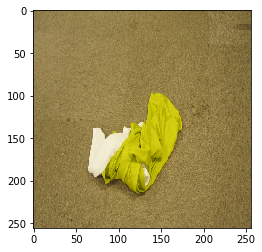

In [5]:
#テスト用imageを取得
class InferenceConfig(ClothConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


from numpy.random import *
"""
#前のやつ 180603 pancho
flag = 0
while(flag == 0):
    testid = randint(100)
    
    if(testid != 1 and testid !=24):
        flag = 1
        
print("test_id:",testid)
test_img_name = "./image/" + str(testid) + "_ex1.png"
test_img = plt.imread(test_img_name)
"""

"""
新たに作ったテストデータ 180603 pancho
"""
testid = randint(10)
testid = 8
        
print("test_id:",testid)
test_img_name = "./test_image/test" + str(testid) + ".JPG"
test_img = cv2.imread(test_img_name)
test_img = cv2.resize(test_img,(256,256))
test_img = test_img[:,:,::-1]
test_original_name = "./test_original_" + str(testid) + ".jpg"
plt.imshow(test_img)
plt.savefig(test_original_name)

#detection
model_path = "/home/pancho_learning/code_MaskR-CNN/mask_rcnn_clothes_0000.h5"
model.load_weights(model_path, by_name=True)
results = model.detect([test_img], verbose=1)

# Visualize Results
r = results[0]
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                           class_name, r["scores"])

test_id: 10
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  240.00000
molded_images            shape: (1, 256, 256, 3)      min: -103.90000  max:  117.20000
image_metas              shape: (1, 12)               min:    0.00000  max:  256.00000


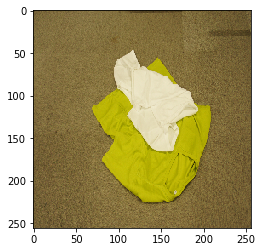

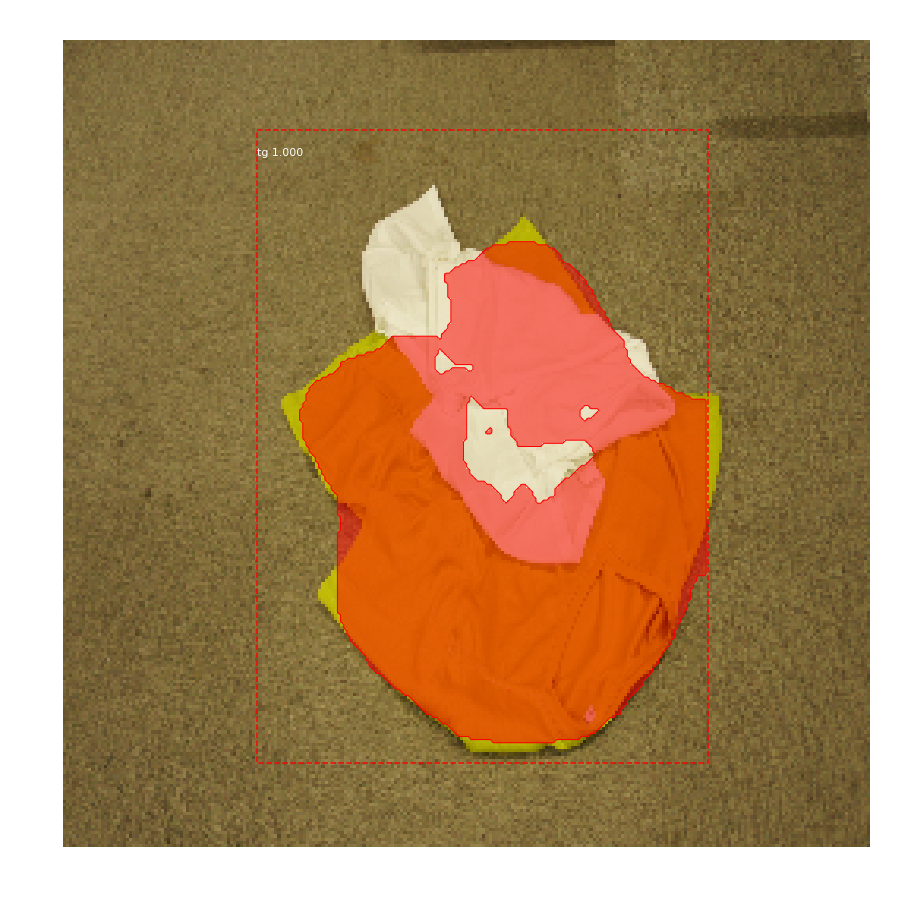

In [59]:
#テスト用imageを取得
class InferenceConfig(ClothConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
class_name = ["BG","tg", "tw"]
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


from numpy.random import *

"""
新たに作ったテストデータ 180603 pancho
"""
#testid = randint(10)
testid = 10
        
print("test_id:",testid)
test_img_name = "./test_image/test" + str(testid) + ".JPG"
test_img = cv2.imread(test_img_name)
test_img = cv2.resize(test_img,(256,256))
test_img = test_img[:,:,::-1]
test_original_name = "./test_original_" + str(testid) + ".jpg"
plt.imshow(test_img)
plt.savefig(test_original_name)

#detection
model_path = "/home/pancho_learning/code_MaskR-CNN/mask_rcnn_clothes_0250.h5"
model.load_weights(model_path, by_name=True)
results = model.detect([test_img], verbose=1)

# Visualize Results
r = results[0]
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                           class_name, r["scores"])

In [14]:
r["masks"].shape

(256, 256, 1)

In [13]:
results[0]["masks"].shape

(256, 256, 11)

## 別の方法 Other Method

In [12]:
class InferenceConfig(ClothConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

ROOT_DIR = os.getcwd()

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()[1]
model_path = os.path.join(ROOT_DIR, "mask_rcnn_clothes_0120.h5")
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
#model_path = "/home/ubuntu/code_MaskR-CNN/mask_rcnn_clothes_0120.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/pancho_learning/code_MaskR-CNN/mask_rcnn_clothes_0120.h5


image_id in [load_image]. 8
image_id 8
shapes [('tw', (0, 0, 255), (2737, 887, 2552)), ('tg', (255, 0, 0), (2278, 1505, 2528))]
enter_mask _R-CNN
width 256
height 256
mask.shape (256, 256, 2)
mask.shape (256, 256, 2)
class_ids [2 1]
original_image           shape: (256, 256, 3)         min:    0.00000  max:  245.00000
image_meta               shape: (11,)                 min:    0.00000  max:  256.00000
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000
gt_bbox                  shape: (2, 4)                min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 2)         min:    1.00000  max:  255.00000


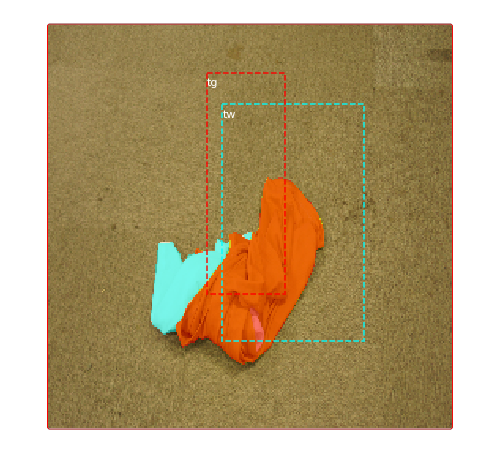

In [61]:
# Test on a random test image
import random
#image_id = random.choice(dataset_test.image_ids)
image_id = 8
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

gt_bbox = np.array([[50,110,200,200],[30,100,170,150]])

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

#print(gt_mask)

In [25]:
r["masks"].shape

(256, 256, 1)

In [24]:
gt_mask.shape

(256, 256, 2)

# gt_maskを用いてsegmetationされた画素数をカウント

In [14]:
#count elements per instance{white Tshirt, green Tshirt, back ground}
num_wPred = np.sum(np.all(gt_mask==[1,255],axis=0).T) 
num_gPred = np.sum(np.all(gt_mask==[255,1],axis=0).T) 
num_backPred = np.sum(np.all(gt_mask==[255,255],axis=0).T)

print("num_wPred",num_wPred)
print("num_gPred",num_gPred)
print("num_backPred",num_backPred)

num_wPred 162
num_gPred 201
num_backPred 363


In [15]:
gt_mask.shape[0]

256

In [16]:
count = 0
for i in range(gt_mask.shape[0]):
    for j in range(gt_mask.shape[1]):
        if np.all(gt_mask[i,j] == np.array([1,255])) or np.any(gt_mask[i,j] == np.array([255,1])) or np.any(gt_mask[i,j] == np.array([255,255])):
            
            count = count + 1

In [17]:
num_wPred = 0
num_gPred = 0
num_backPred = 0

for i in range(gt_mask.shape[0]):
    for j in range(gt_mask.shape[1]):
        if np.all(gt_mask[i,j] == np.array([1,255])): #モデルが白Tシャツだと予測
            num_wPred = num_wPred + 1
        elif np.all(gt_mask[i,j] == np.array([255,1])):
            num_gPred = num_gPred + 1
        else: num_backPred = num_backPred + 1
            
print("num_wPred",num_wPred)
print("num_gPred",num_gPred)
print("num_backPred",num_backPred)
print("num of elements",num_wPred + num_gPred + num_backPred)

num_wPred 1575
num_gPred 5731
num_backPred 58230
num of elements 65536


In [18]:
num_wPred + num_gPred + num_backPred

65536

In [19]:
gt_bbox = np.array([[100,30,150,170],[110,50,200,200]])

In [20]:
gt_mask.shape

(256, 256, 2)

# IoUを算出する

IoU = TP/(TP + FP + FN)

In [21]:
import cv2

TP = 0
FP = 0
FN = 0

test_id = 8

path = "test_image/test" + str(test_id) + "_label.png"

test_image = cv2.imread(path)
test_image = cv2.resize(test_image,(256,256))
height = gt_mask.shape[0]
width = gt_mask.shape[1]

for i in range(height):
    for j in range(width):
        if np.all(gt_mask[i,j] == np.array([255,1])): #for Green Tshirts
            if all(test_image[i,j] == np.array([0,0,255])):
                TP = TP + 1
            else:
                FP = FP + 1
        elif np.all(gt_mask[i,j] == np.array([1,255])): #for White Tshirts
            if all(test_image[i,j] == np.array([255,0,0])):
                TP = TP + 1
            else:
                FP = FP + 1
        elif np.all(gt_mask[i,j] == np.array([255,255])):
            if all(test_image[i,j] == np.array([0,0,255])) or all(test_image[i,j] == np.array([255,0,0])):
                FN = FN + 1

IoU = TP/(TP + FN + FP)
                
print("TP",TP)
print("FP",FP)
print("FN",FN)
print("IoU", IoU)

TP 7306
FP 0
FN 0
IoU 1.0


# IoU 180720- 緑のTシャツのみ出す。

In [66]:
#テスト用imageを取得
class InferenceConfig(ClothConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
class_name = ["BG","tg", "tw"]
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)



import cv2


numTest = 10
IoUs = []

test_id = 8

TP = 0
FP = 0
FN = 0

#モデルの予測結果を

path_img = "test_image/test" + str(test_id) + ".JPG"
path_label = "test_image/test" + str(test_id) + "_label.png"


test_img = cv2.imread(path_img)
test_img = cv2.resize(test_img,(256,256))
test_img = test_img[:,:,::-1]

#detection
model_path = "/home/pancho_learning/code_MaskR-CNN/mask_rcnn_clothes_0250.h5"
model.load_weights(model_path, by_name=True)
results = model.detect([test_img], verbose=1)

# Visualize Results
r = results[0]



label_img = cv2.imread(path_label)
label_img = cv2.resize(label_image,(256,256))
height = gt_mask.shape[0]
width = gt_mask.shape[1]


for i in range(height):
    for j in range(width):
        if r["masks"][i,j] == 1: #モデルが緑だと予想
            if all(label_img[i,j] == np.array([0,0,255])):
                TP = TP + 1
            else:
                FP = FP + 1
        elif r["masks"][i,j] == 0: #モデルが何もないと予測(背景か白Tシャツ)
            if all(test_image[i,j] == np.array([0,0,255])):
                FN = FN + 1


IoU = TP/(TP + FN + FP)

print("TP",TP)
print("FP",FP)
print("FN",FN)

print("IoU", IoU)


    

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  245.00000
molded_images            shape: (1, 256, 256, 3)      min: -103.90000  max:  123.20000
image_metas              shape: (1, 12)               min:    0.00000  max:  256.00000
TP 5550
FP 259
FN 181
IoU 0.9265442404006677


## IoU 180720- 緑のTシャツのみ出す。 全テスト画像用



In [4]:
import cv2



#テスト用imageを取得
class InferenceConfig(ClothConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
class_name = ["BG","tg", "tw"]
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = "/home/pancho_learning/code_MaskR-CNN/mask_rcnn_clothes_0250.h5"
model.load_weights(model_path, by_name=True)






IoUs = []

num = 10

for ID in range(num):

    
    
    TP = 0
    FP = 0
    FN = 0

    path_img =  "test_image/test" + str(ID+1) + ".JPG"
    path_label = "test_image/test" + str(ID+1) + "_label.png"
    
    print("path_img.", path_img)
    print("path_label", path_label)
    
    #モデルを使って予測
    
    # Recreate the model in inference mode
    
    
    test_img = cv2.imread(path_img)
    test_img = cv2.resize(test_img,(256,256))
    test_img = test_img[:,:,::-1]
    results = model.detect([test_img], verbose=1)
    r = results[0]
    
    
    label_img = cv2.imread(path_label)
    label_img = cv2.resize(label_img,(256,256))
    label_img = label_img[:,:,::-1]
    
    height = 256
    width = 256


    for i in range(height):
        for j in range(width):
            if r["masks"][i,j] == 1: #モデルが緑だと予想
                if all(label_img[i,j] == np.array([255,0,0])): #ラベルも緑
                    TP = TP + 1
                else:
                    FP = FP + 1
            elif r["masks"][i,j] == 0: #モデルが何もないと予測(背景か白Tシャツ)
                if all(label_img[i,j] == np.array([255,0,0])): #緑色のTシャツがある場合
                    FN = FN + 1


    IoU = TP/(TP + FN + FP)
    IoUs.append(IoU)                
    print("")
    print("TP",TP)
    print("FP",FP)
    print("FN",FN)
    print("IoU", IoU)
    print("")

print("IoUs:", IoUs)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
path_img. test_image/test1.JPG
path_label test_image/test1_label.png
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  236.00000
molded_images            shape: (1, 256, 256, 3)      min: -103.90000  max:  112.30000
image_metas              shape: (1, 12)               min:    0.00000  max:  256.00000

TP 12299
FP 135
FN 1436
IoU 0.8867339581831291

path_img. test_image/test2.JPG
path_label test_image/test2_label.png
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  235.00000
molded_images            shape: (1, 256, 256, 3)      min: -103.90000  max:  111.30000
image_metas              shape: (1, 12)               min:    0.00000  max:  256.00000

TP 4288
FP 66
FN 1606
IoU 0.7194630872483222

path_img. test_image/test3.JPG
path_label test_image/test3

In [5]:
from statistics import mean, median,variance,stdev

mIoU = mean(IoUs)
print("mIoU: ", mIoU)

mIoU:  0.8067823633629553


[]

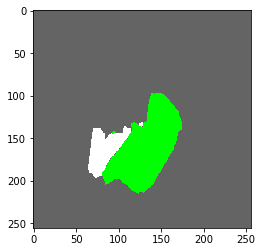

In [86]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

height = gt_mask.shape[0]
width = gt_mask.shape[1]

image = np.zeros((height,width,3),np.uint8)

for i in range(height):
    for j in range(width):
        if np.all(gt_mask[i,j] == np.array([255,1])): #for Green Tshirts
            image[i,j] = np.array([0,255,0])
        elif np.all(gt_mask[i,j] == np.array([1,255])):
            image[i,j] = np.array([255,255,255])
        elif np.all(gt_mask[i,j] == np.array([255,255])):
            image[i,j] = np.array([100,100,100])
            
plt.imshow(image[:,:,::-1])
plt.plot()

In [79]:
image.shape

(256, 256, 3)

# r["masks"]の結果をプロットしてみる

[]

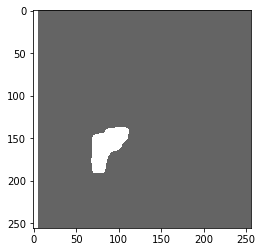

In [99]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

height = gt_mask.shape[0]
width = gt_mask.shape[1]

image = np.zeros((height,width,3),np.uint8)

for i in range(height):
    for j in range(width):
        if np.all(r["masks"][i,j] != np.array([1])): #for White Tshirts
            image[i,j] = np.array([255,255,255])
        else: image[i,j] = np.array([100,100,100])
            
plt.imshow(image[:,:,::-1])
plt.plot()

In [96]:
r["masks"][0,0]

array([0], dtype=uint8)

In [97]:
r["masks"]

array([[[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)